# Convert data set into R, G, and B arrays

In [5]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage import io

In [6]:
# input     folder full of forhead images labelled numerically
# output:   three strings
def RGB_channels(frames_source):
   
    filelist = os.listdir(frames_source)
    filelist = sorted(filelist)
    
    R_avg = np.zeros(0, dtype = int) #zeros(len(filelist))
    G_avg = np.zeros(0, dtype = int)
    B_avg = np.zeros(0, dtype = int)

    for filename in filelist:
        if filename.endswith(".png"):
            path_image = os.path.join(frames_source, filename)
            imageRGB = io.imread(path_image)
            imageR = np.zeros(imageRGB.shape, dtype=int)
            imageG = np.zeros(imageRGB.shape, dtype=int)
            imageB = np.zeros(imageRGB.shape, dtype=int)
            imageR[:,:,0] = imageRGB[:,:,0]
            imageG[:,:,1] = imageRGB[:,:,1]
            imageB[:,:,2] = imageRGB[:,:,2]
            
            shape = np.shape(imageR)
            dim = shape[0]*shape[1]
            R_avg = np.append(R_avg, imageR.sum()/dim)
            G_avg = np.append(G_avg, imageG.sum()/dim)
            B_avg = np.append(B_avg, imageB.sum()/dim)
            
#             if(filename == "1.png"):
#                 plt.figure(figsize=(15,6))
#                 plt.subplot(131) 
#                 plt.imshow(imageR)
#                 plt.title('Average red pixel of frame 1 is ' + str(int(R_avg[-1])))
#                 plt.subplot(132)
#                 plt.imshow(imageG)
#                 plt.title('Average green pixel of frame 1 is ' + str(int(G_avg[-1])))
#                 plt.subplot(133)
#                 plt.imshow(imageB)
#                 plt.title('Average blue pixel of frame 1 is ' + str(int(B_avg[-1])))
        
    return R_avg, G_avg, B_avg
            

In [7]:
#fill this in with the video to be turned into a forehead video
#run this box
frames_source = "anthony_fps29.986"

Rs, Gs, Bs = RGB_channels(frames_source)

In [8]:
from scipy import sparse
from scipy import linalg
from scipy import signal

In [17]:
def normalize(input_array):
    average = np.average(input_array)
    standard_deviation = np.std(input_array)
    subtract = np.subtract(input_array,average)
    normalize = subtract/standard_deviation
    return normalize
def detrend_advance(input_array, Lambda):
    T = input_array.size
    I = sparse.identity(T)
    # print("Identity shape: " + str(I.shape))
    D2 = sparse.diags([1,-2,1],[0,1,2],(T-2,T))
    # print(D2.shape)
    D2_T = (D2.toarray()).T
    # print("D2_T shape: " + str(D2_T.shape))
    D2_product = (D2_T).dot(D2.toarray())
    # print("D2_product shape: " + str( D2_product.shape))
    Lambda_2 = Lambda**2
    SUM = I + (D2_product*Lambda_2)
    # print("SUM shape: " + str(SUM.shape))
    inv = linalg.inv(SUM)
    # print("Inv Shape:" + str(inv.shape))
    DIFF = I - inv
    # print("DIFF shape: " + str(DIFF.shape))
    z_stat = DIFF.dot(input_array)
    # print("z_stat shape: " + str(z_stat.shape))
    # print(z_stat)
    z_stat = np.reshape(z_stat,(T,1), 'C' )
    # print(z_stat)
    # print("z_stat shape: " + str(z_stat.shape))
    #plt.stem(z_stat)
    return z_stat
def moving_average(values,window):
    weights = np.repeat(1.0,window) / window
    weights = np.reshape(weights, (weights.size,1))
    smas = signal.convolve2d(values,weights, 'valid')
    return smas
def dft(signal): 
    frameRate = 29.986 #30 frames per second
    T = 1/frameRate
    lengthOfVideo = 30
    fourierTransform = np.fft.rfft2(signal) # / signal.size
    inv_dft = np.fft.ifft2(fourierTransform)
    figure, graph = plt.subplots(2, 1, figsize = (20,10))
    figure.tight_layout(pad=3.0)
    graph[0].plot(fourierTransform)
    graph[1].plot(inv_dft)
    positiveFFT = np.abs(fourierTransform)
    frequencies = np.fft.fftfreq(signal.size)
    CFT = positiveFFT * T
    C_frequencies = frequencies * 2*np.pi / ((signal.size)*T)
#     print("Frequencies shape: " + str(frequencies.shape))
#     print("Frequencies: ")
#     print(frequencies)
    return frequencies, positiveFFT, C_frequencies, CFT
def highestPeak(signal, frequencies,fft, fps):
    frequency = frequencies[np.argmax(fft)] #gets frequency at the max index value of fft (1 per frame).
    Hz = frequency * 2 *np.pi 
    print("Hz: " + str(Hz))
    return Hz

725


C:\Users\antho\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Hz: 0.14639141777593725
bpm: 8.783485066556235


<Container object of 3 artists>

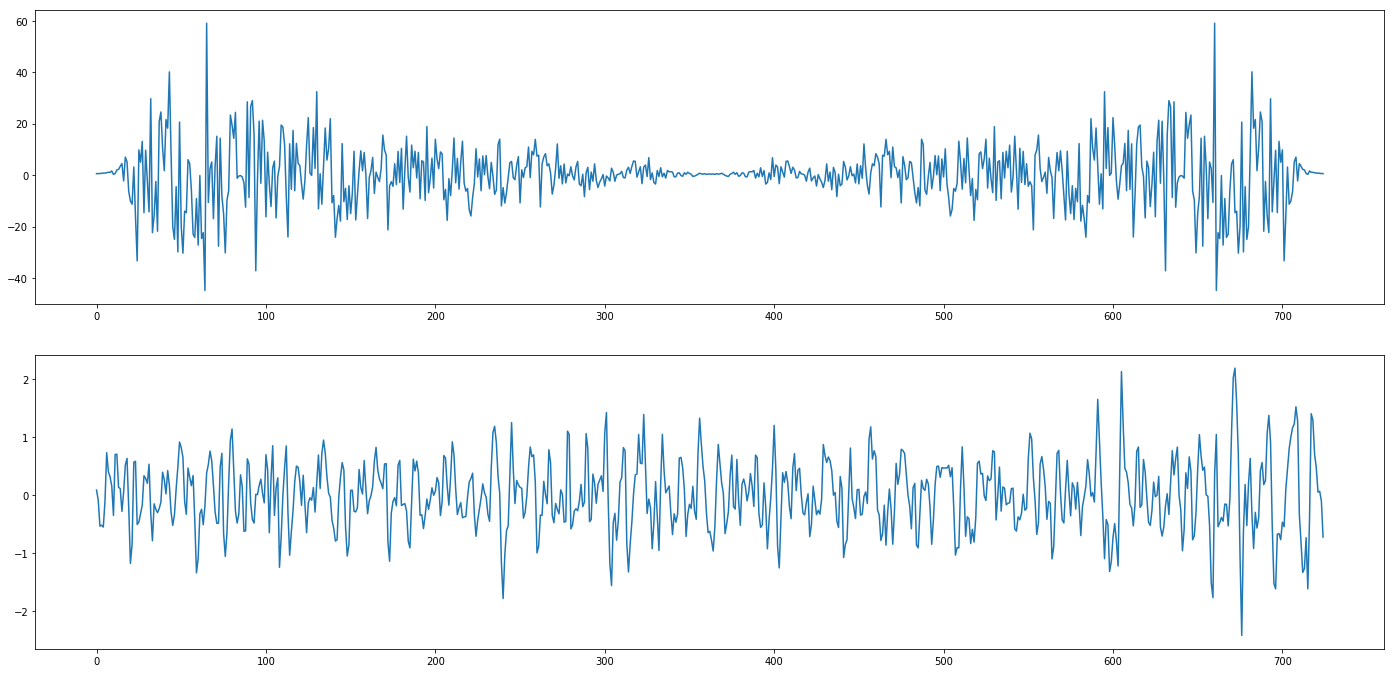

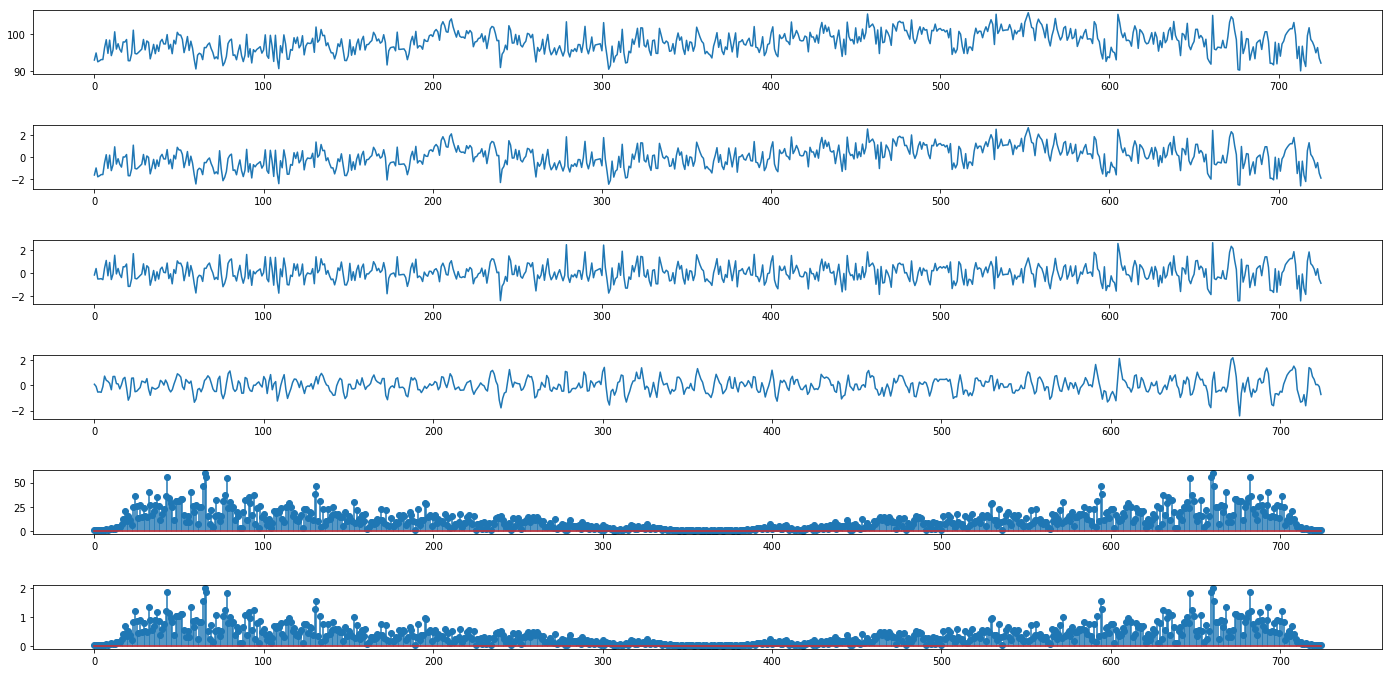

In [18]:
norm_mat = normalize(Gs[200:])

z_stat = detrend_advance(norm_mat, 29.986)
mv_mat = moving_average(z_stat,2)
print(mv_mat.size)
frequencies, positiveFFT, C_frequencies, CFT = dft(mv_mat)
# freq = highestPeak(mv_mat, frequencies, positiveFFT,29.986)
freq = highestPeak(mv_mat, C_frequencies, CFT,29.986)

bpm = freq*60
print("bpm: " + str(bpm))
plt.figure(figsize=(15,6))
figure, graph = plt.subplots(6, 1, figsize = (20,10))
figure.tight_layout(pad=3.0)
graph[0].plot(Gs[200:])
graph[1].plot(norm_mat)
graph[2].plot(z_stat)
graph[3].plot(mv_mat)
graph[4].stem(positiveFFT)
graph[5].stem(CFT)